In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import json

## Create a final maps from clustering results

In [3]:
# File path
rgb_data_path = 'data/Allsky_Gaia_42481846_extinction_corrected_filtered.fits'

# Load the FITS file with data used in this analysis
with fits.open(rgb_data_path, memmap=True) as hdul:
    data = hdul[1].data 
    ra = data['ra']
    dec = data['dec']
    l = data['l']
    b = data['b']
    dered_G = data['dered_G']
    dered_BP_RP = data['dered_BP_RP']
    pm = (data['pmra'] **2 + data['pmdec'] **2)**(1/2)


mag_bins = [14., 18.5]

# -------------------------------
# Global filter: color + magnitude
# -------------------------------
w = (dered_BP_RP > 1.0) & (dered_G > mag_bins[0]) & (dered_G < mag_bins[1]) & (abs(b)>10)

# Apply to all relevant arrays
ra = ra[w]
dec = dec[w]
l = l[w]
b = b[w]
dered_G = dered_G[w]
dered_BP_RP = dered_BP_RP[w]
pm = pm[w]

# -------------------------------
# All-sky dataframe (Galactic)
# -------------------------------
all_sky = pd.DataFrame({
    'l': l,
    'b': b,
    'dered_G': dered_G,
    'ra': ra,
    'dec': dec,
    'dered_G': dered_G,
    'dered_BP_RP': dered_BP_RP,
    'pm': pm
})

# Collect Results from both 6.1 and 6.2
## There is chaging of the names here 
- `Terzan 7, Arp 2, Terzan 8` is likely the clustering identifying the stream 
- `LMC, Pictor II` is simply displayed as LMC as a single cluster was found 
- It stops diplicates from both clusters being identified

In [4]:
# Load matched clusters from the JSON file
with open("data/matched_clusters_LowerPM.json", "r") as f:
    matched_clusters_dict_lower = json.load(f)

with open("data/matched_clusters_HigherPM.json", "r") as f:
    matched_clusters_dict_higher = json.load(f)

merged_clusters_dict = matched_clusters_dict_higher.copy()

for cluster_name, cluster_data in matched_clusters_dict_lower.items():
    if cluster_name == 'LMC, Pictor II':
        continue
    if cluster_name == 'Terzan 7, Arp 2, Terzan 8':
        cluster_name = 'Stream'
    if cluster_name not in merged_clusters_dict: 
        merged_clusters_dict[cluster_name] = cluster_data

# Convert merged dictionary into a list for plotting
cluster_ranges = [
    (cluster_name, data["l_min"], data["l_max"], data["b_min"], data["b_max"])
    for cluster_name, data in merged_clusters_dict.items()
]



# Total Clusters Found...

In [5]:
print(f"Number of clusters automatically identified: {len(cluster_ranges)}")

Number of clusters automatically identified: 43


In [6]:
def plot_rgb_sky_rectangular(gaia_data, cluster_ranges, nside=128, contrast=(5, 95), binning_method="linear"):

    l = gaia_data['l'].values  # Galactic longitude
    b = gaia_data['b'].values  # Galactic latitude
    mag = gaia_data['dered_G'].values  # Magnitude

    # Convert RA/Dec to Galactic Coordinates
    theta = np.radians(90 - b)  # Healpy uses theta = 90° - Dec
    phi = np.radians(l)          # Healpy uses phi = RA

    mag_low, mag_high = np.percentile(mag, 1), np.percentile(mag, 99)

    # --------- Compute Healpy Binning for Sky Density ---------
    npix = hp.nside2npix(nside)
    density_map = np.zeros(npix)

    pix_indices = hp.ang2pix(nside, theta, phi)
    np.add.at(density_map, pix_indices, 1)  # Count stars per pixel

    # Determine contrast scaling
    non_zero = density_map[density_map > 0]
    # vmin, vmax = np.percentile(non_zero, contrast[0]), np.percentile(non_zero, contrast[1])

    # --------- Compute RGB Magnitude Bins ---------
    def compute_rgb_bins(mag, method= binning_method):
        """ 
        Compute RGB bins using either 'linear' or 'normal' binning.

        Parameters:
            mag (array-like): Magnitude values.
            method (str): 'linear' for equal-width bins, 'normal' for normal distribution binning.

        Returns:
            list: Three bin edges for R/G/B assignment.
        """
        mag = np.array(mag)
        mag = mag[np.isfinite(mag)]  # Remove NaN values


        if method == "linear":
            middle_bins = np.linspace(mag_low, mag_high, 4)  # Three bins
            end_bins = np.linspace(np.min(mag), np.max(mag), 4)  
            middle_bins[0] = end_bins[0]
            middle_bins[3] = end_bins[3]

            return middle_bins  # Three bins

        elif method == "normal":
            return [np.min(mag), np.percentile(mag, 33), np.percentile(mag, 66), np.max(mag)]
        
        elif isinstance(method, tuple):
            return [np.min(mag), method[0], method[1], np.max(mag)]

        else:
            raise ValueError("Invalid method. Choose 'linear' or 'normal'.")

    # Compute RGB magnitude bins
    rgb_bins = compute_rgb_bins(mag, binning_method)



    # --------- Create False-Color RGB Composite : Rectangular View ---------
    rgb_masks = [(mag >= rgb_bins[i]) & (mag < rgb_bins[i+1]) for i in range(3)]
    
    density_maps_rgb = []
    for mask in rgb_masks:
        density_map_channel = np.zeros(npix)
        pix_indices_channel = hp.ang2pix(nside, theta[mask], phi[mask])
        np.add.at(density_map_channel, pix_indices_channel, 1)
        density_maps_rgb.append(density_map_channel)

    # Normalize each channel
    def normalize_channel(channel):
        """ Normalize a HEALPix map to the [0,1] range. """
        if channel.max() > 0:
            vmin, vmax = np.percentile(channel[channel > 0], [contrast[0], contrast[1]])
            return np.clip((channel - vmin) / (vmax - vmin), 0, 1)
        return channel

    # Normalize each RGB channel separately
    r_channel = normalize_channel(density_maps_rgb[2])  # Faintest stars (Red)
    g_channel = normalize_channel(density_maps_rgb[1])  # Medium brightness (Green)
    b_channel = normalize_channel(density_maps_rgb[0])  # Brightest stars (Blue)

    # Stack into RGB image (N_pixels, 3)
    rgb_healpix_map = np.stack([r_channel, g_channel, b_channel], axis=-1)  # Shape (N_pixels, 3)

    # Convert HEALPix pixel indices to sky coordinates
    nside = hp.get_nside(r_channel)
    theta, phi = hp.pix2ang(nside, np.arange(rgb_healpix_map.shape[0]))

    # Convert to RA/Dec (or Galactic coordinates)
    # Convert HEALPix angles to Galactic Coordinates
    l = np.degrees(phi)  # Galactic longitude
    b = 90 - np.degrees(theta)  # Galactic latitude

    # Ensures -180° to +180° range
    l = -((l + 180) % 360 - 180)  


    fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

    # Scatter plot of RGB composite with correct orientation
    sc = ax.scatter(
        l, b, 
        c=rgb_healpix_map,
        marker="o",
        s=200,
        edgecolor="none") 

    # Set axis labels and title
    ax.set_xlabel("Galactic Longitude (l)", fontsize=14)
    ax.set_ylabel("Galactic Latitude (b)", fontsize=14)

    # Set Galactic coordinate limits
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)

    # --------- Overlay Cluster Bins ---------
    color = 'white'
    for cluster in cluster_ranges:
        name, l_min, l_max, b_min, b_max = cluster[:5]  

        # Flip Galactic Longitude if needed
        l_min_transformed = -((l_min + 180) % 360 - 180)
        l_max_transformed = -((l_max + 180) % 360 - 180)
        if l_min_transformed > l_max_transformed:
            l_min_transformed, l_max_transformed = l_max_transformed, l_min_transformed

        # Plot Cluster Bounding Box
        ax.plot(
            [l_min_transformed, l_max_transformed, l_max_transformed, l_min_transformed, l_min_transformed],
            [b_min, b_min, b_max, b_max, b_min],
            linestyle='-', color=color, linewidth=1
        )

        # Add Labels to Certain Clusters
        if name in ['NGC 5053', 'NGC 5466', 'NGC 6341', 'NGC 7089', 'NGC 6205', 'NGC 5904', 'NGC 3201']:
            ax.text(l_max_transformed, b_min, name, fontsize=12, color=color, ha='left', va='top', fontweight='bold')
        elif name in ['Sagittarius', 'NGC 5286', 'NGC 104', 'NGC 2419']:
            ax.text(l_max_transformed, b_min, name, fontsize=12, color=color, ha='right', va='bottom', fontweight='bold')
        elif name in ['NGC 362']:
            ax.text(l_max_transformed, b_min, name, fontsize=12, color=color, ha='right', va='top', fontweight='bold')
        elif name.startswith('T'):
            ax.text(l_max_transformed, b_min, f"{name[:9]}\n{name[10:16]}\n{name[17:25]}", fontsize=12, color=color, ha='left', va='top', fontweight='bold')
        elif name != "N/A":
            ax.text(l_max_transformed, b_min, name, fontsize=12, color=color, ha='left', va='bottom', fontweight='bold')

    plt.show()
    
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.show()


## True Clusters Identified

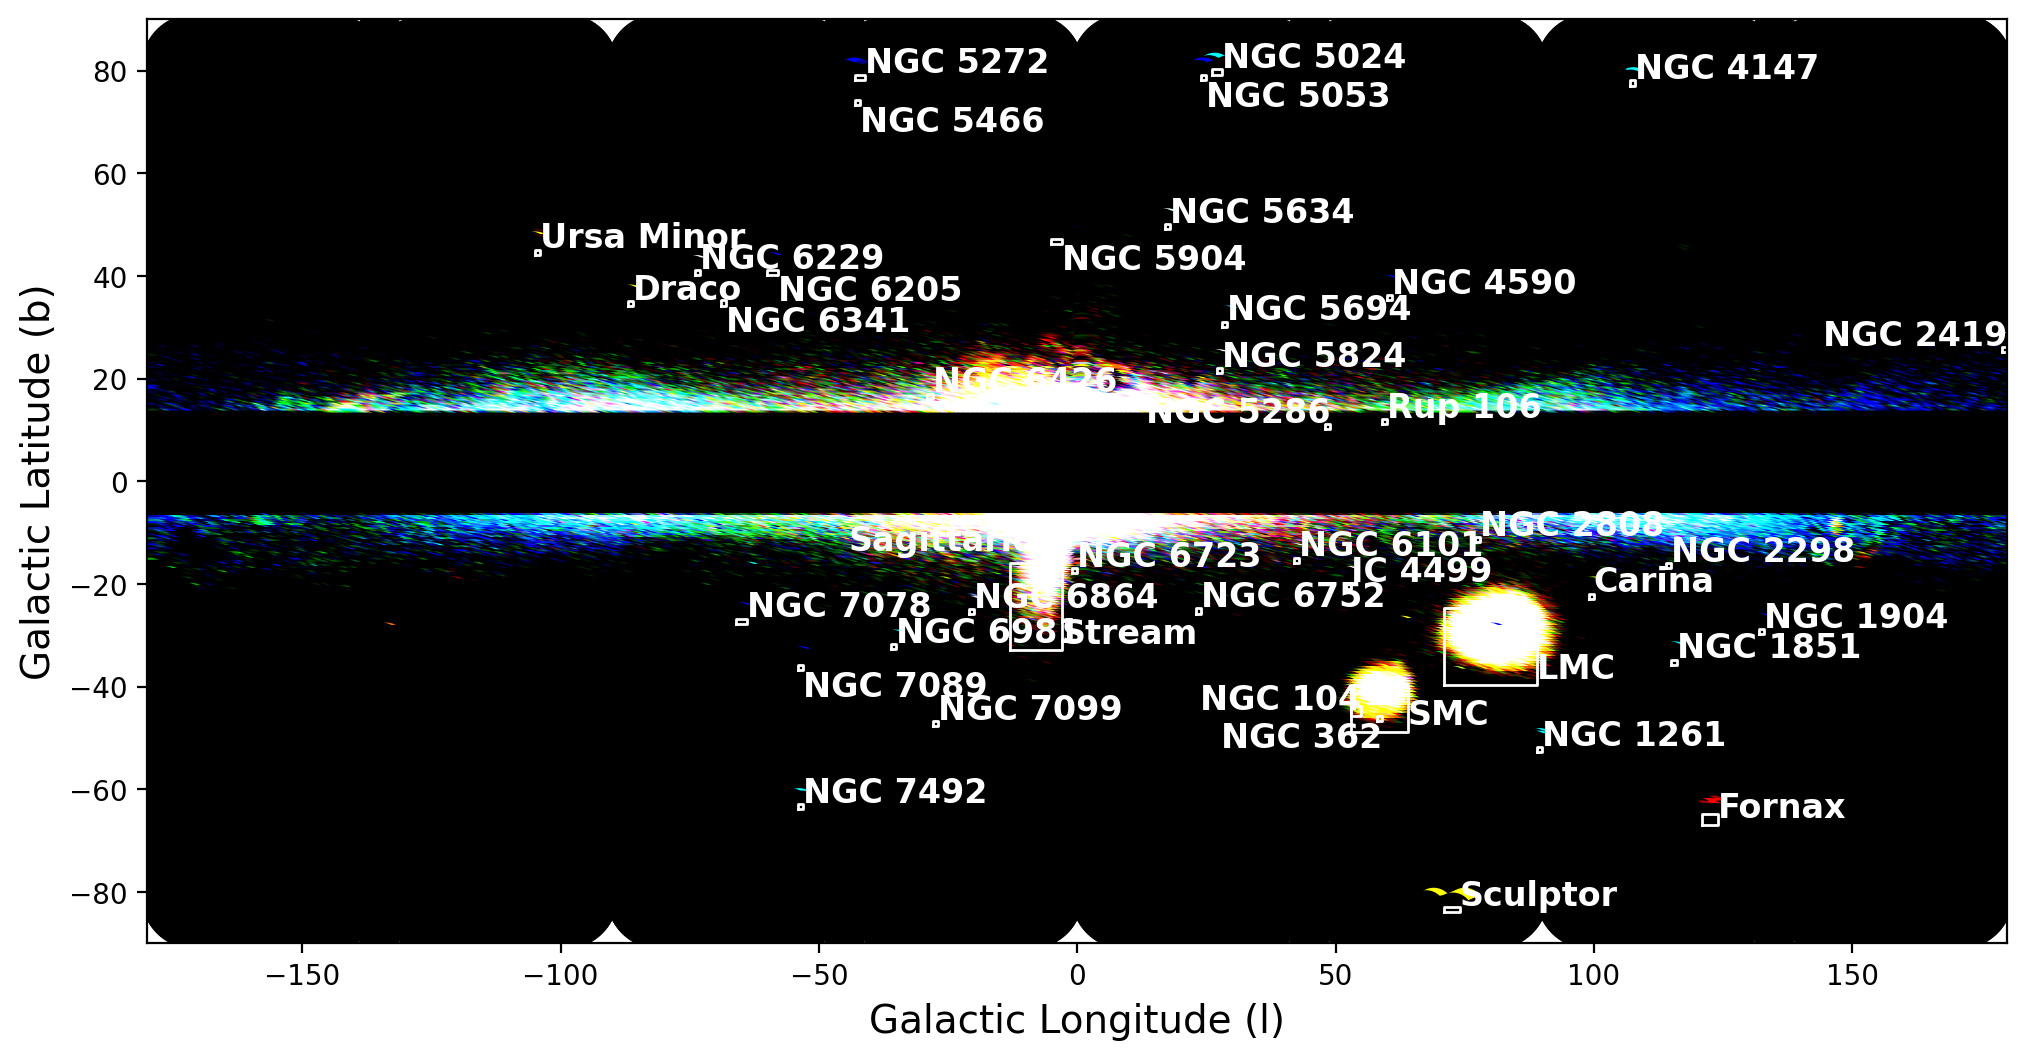

In [7]:
plot_rgb_sky_rectangular(all_sky, cluster_ranges, nside=100, contrast=(80, 93), binning_method="normal")



# Second Plot - Same data on better background

In [8]:
# File path
rgb_data_path = 'data/Allsky_Gaia_42481846_extinction_corrected_filtered.fits'

# Load the FITS file with data used in this analysis
with fits.open(rgb_data_path, memmap=True) as hdul:
    data = hdul[1].data 
    ra = data['ra']
    dec = data['dec']
    l = data['l']
    b = data['b']
    dered_G = data['dered_G']
    dered_BP_RP = data['dered_BP_RP']
    pm = (data['pmra'] **2 + data['pmdec'] **2)**(1/2)


mag_bins = [14., 18.5]

# -------------------------------
# Global filter: color + magnitude
# -------------------------------
w = (dered_BP_RP > 1.0) & (dered_G > mag_bins[0]) & (dered_G < mag_bins[1]) & (abs(b)>10)

# Apply to all relevant arrays
ra = ra[w]
dec = dec[w]
l = l[w]
b = b[w]
dered_G = dered_G[w]
dered_BP_RP = dered_BP_RP[w]
pm = pm[w]

# -------------------------------
# All-sky dataframe (Galactic)
# -------------------------------
all_sky = pd.DataFrame({
    'l': l,
    'b': b,
    'dered_G': dered_G,
    'ra': ra,
    'dec': dec,
    'dered_G': dered_G,
    'dered_BP_RP': dered_BP_RP,
    'pm': pm
})

In [9]:
print(len(cluster_ranges))

43


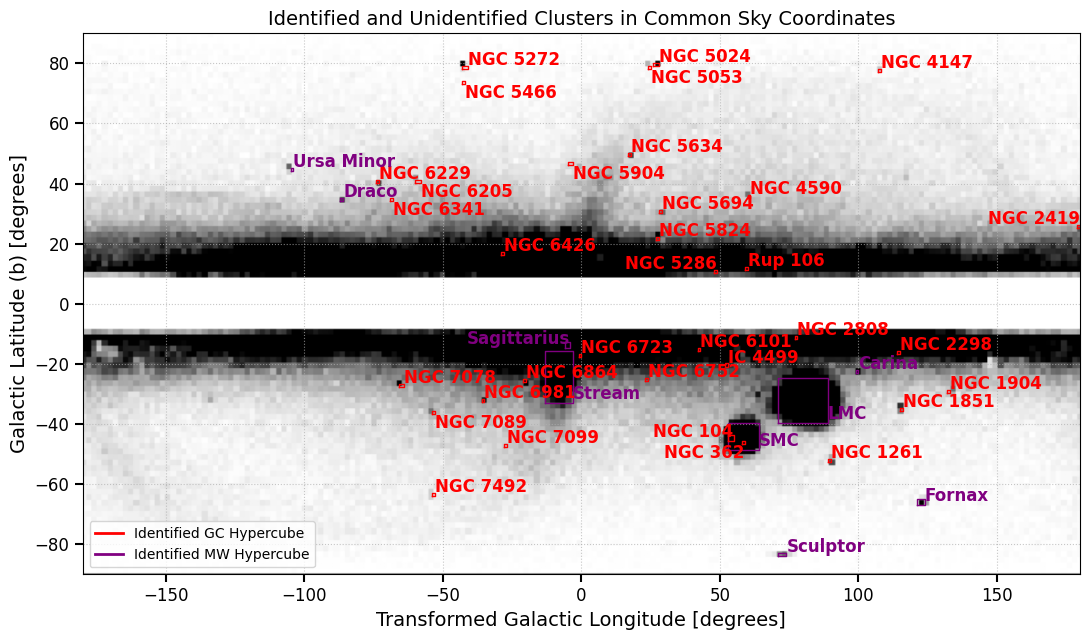

In [11]:
# ------------------------------
# PLOTTING PARAMETERS
# ------------------------------
figsize_wide = (11, 6.5)
figsize_moll = (12, 6)
fontsize_labels = 16
fontsize_ticks = 14
fontsize_title = 18
tick_length = 6
tick_width = 1.5

# ------------------------------
# DATA EXTRACTION
# ------------------------------
l = all_sky['l'].values
b = all_sky['b'].values
ra = all_sky['ra'].values
dec = all_sky['dec'].values
mag = all_sky['dered_G'].values
pm = all_sky['pm'].values
dered_G = all_sky['dered_G'].values
dered_BP_RP = all_sky['dered_BP_RP'].values


ra_range=[0,360]
dec_range=np.array([-90,90])
rev_rar_range=np.flip(ra_range)
nra = int(1*360)
ndec = int(1*180)

den, xedges, yedges = np.histogram2d(ra, dec, bins=(nra, ndec))
# For bins that are empty set to a very small value
w0 = den == 0
wn0 = den !=0
den[w0] = 1e-6
# Apply log scaling
den_log = np.log10(den)

ra_range_shifted = [-180, 180]  # updated range

# Shift longitudes so Galactic center (l=0) is centered
l_shifted = (-l + 180) % 360 - 180
b_vals = b

# Plot
fig, ax = plt.subplots(figsize=figsize_wide)

den, xedges, yedges = np.histogram2d(l_shifted, b_vals, bins=(nra, ndec), range=[ra_range_shifted, dec_range])



### --- Background ----
bg_image = plt.imread("backgroundimage/background.png")

plt.imshow(bg_image,
           extent=[-180, 180, -90, 90],  
           aspect='auto',
           alpha=1,             
           zorder=0)  



# --------- Overlay Cluster Bins ---------
for cluster in cluster_ranges:
        name, l_min, l_max, b_min, b_max = cluster[:5] 
        
        if name in ['LMC', 'SMC', 'Ursa Minor', 'Carina', 'Sagittarius', 'Draco', 'Fornax', 'Sculptor', 'Stream']:
                color = 'purple'
        else:
                color = 'red'

        # Flip Galactic Longitude if needed
        l_min_transformed = -((l_min + 180) % 360 - 180)
        l_max_transformed = -((l_max + 180) % 360 - 180)
        if l_min_transformed > l_max_transformed:
                l_min_transformed, l_max_transformed = l_max_transformed, l_min_transformed

        # Plot Cluster Bounding Box
        ax.plot(
                [l_min_transformed, l_max_transformed, l_max_transformed, l_min_transformed, l_min_transformed],
                [b_min, b_min, b_max, b_max, b_min],
                linestyle='-', color=color, linewidth=1
        )


        # Add Labels to Certain Clusters
        if name in ['NGC 5053', 'NGC 5466', 'NGC 6341', 'NGC 7089', 'NGC 6205', 'NGC 5904', 'NGC 3201']:
                ax.text(l_max_transformed, b_min, name, fontsize=12, color=color, ha='left', va='top', fontweight='bold')
        elif name in ['Sagittarius', 'NGC 5286', 'NGC 104', 'NGC 2419']:
                ax.text(l_max_transformed, b_min, name, fontsize=12, color=color, ha='right', va='bottom', fontweight='bold')
        elif name in ['NGC 362']:
                ax.text(l_max_transformed, b_min, name, fontsize=12, color=color, ha='right', va='top', fontweight='bold')
        elif name.startswith('T'):
                ax.text(l_max_transformed, b_min, f"{name[:9]}\n{name[10:16]}\n{name[17:25]}", fontsize=12, color=color, ha='left', va='top', fontweight='bold')
        elif name != "N/A":
                ax.text(l_max_transformed, b_min, name, fontsize=12, color=color, ha='left', va='bottom', fontweight='bold')
                

# Axes

ax.set_xlim(ra_range_shifted)
ax.set_ylim(dec_range)
ax.set_xlabel("Galactic Longitude (l) [deg]", fontsize=fontsize_labels)
ax.set_ylabel("Galactic Latitude (b) [deg]", fontsize=fontsize_labels)
ax.set_title("All Indentified Structures", fontsize=fontsize_title)
ax.tick_params(axis='both', labelsize=fontsize_ticks, length=tick_length, width=tick_width)
# --- Add Custom Legend ---
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Identified GC Hypercube'),
    Line2D([0], [0], color='purple', lw=2, label='Identified MW Hypercube')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=10)




# Labels and formatting
plt.xlabel("Transformed Galactic Longitude [degrees]", fontsize=14)
plt.ylabel("Galactic Latitude (b) [degrees]", fontsize=14)
plt.title("Identified and Unidentified Clusters in Common Sky Coordinates", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.grid(True, linestyle=":", alpha=0.7)  

plt.tight_layout()
plt.show()
